# Similarity in samples - PCA

Creating PCA plots of the samples when considering the transcriptomic or fluxomic variables.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#import self-made functions
%run '/Users/mariekececilia/Documents/master_thesis_code/methods.ipynb'

In [3]:
#figure saving settings for this Notebook
plt.style.use('ggplot')
figure_format = 'pdf'
folder_path_figures = 'Figures/'

In [4]:
#update math text font to match latex
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Charter' #same font as in Latex document
plt.rcParams['mathtext.it'] = 'Serif:italic' #closest to Latex font (couldn't find Charter italic font)
plt.rcParams['mathtext.bf'] = 'Serif:bold' #cloeset to Latex font (couldn't find Charter bold font)

In [5]:
#set a random seed to make reproducible results (used in PCA)
seed = 0

## Load and clean data

In [6]:
#load data
gexp_g, flux_g = load_gerosa()
gexp_i, flux_i = load_ishii()

#split Ishii data into GR and KO subsets
gexp_i_gr, gexp_i_ko = split_ishii(gexp_i)
flux_i_gr, flux_i_ko = split_ishii(flux_i) 

#remove duplicated genes, only relevant for gerosa:
gexp_g, _ = clean_gexp_g(gexp_g)

#remove constant, duplicated, and external reactions + reactions with many null entries: 
flux_g, _ = clean_gerosa(flux_g)
flux_i_gr, _ = clean_ishii(flux_i_gr)
flux_i_ko, _ = clean_ishii(flux_i_ko)

## Prepare data for analysis

In [7]:
#Calculate absolute fluxes because amount of required enzyme is independent of flux direction 
flux_g = flux_g.abs()
flux_i_gr = flux_i_gr.abs()
flux_i_ko = flux_i_ko.abs()

#Log transfrom data to meet PCA assumptions. Need to add constant value to datasets where 0 is present. 
gexp_g = gexp_g.apply(lambda x: np.log(x))
gexp_i = gexp_i.apply(lambda x: np.log(x))
flux_g = flux_g.apply(lambda x: np.log(x+0.01))
flux_i_gr = flux_i_gr.apply(lambda x: np.log(x+0.01))
flux_i_ko = flux_i_ko.apply(lambda x: np.log(x+0.01))

#standardization is performed inside the method which calcualtes the PCs

In [8]:
#nested lists of data and its metadata: [transcriptomic, fluxomic] -> [data, data_name, response, perturbation]
datasets_g = [[gexp_g,'Gerosa','transcriptomic','Carbon source'], 
              [flux_g,'Gerosa','fluxomic','Carbon source']]
datasets_i_gr = [[gexp_i_gr,'Ishii GR','transcriptomic','Growth rate'], 
                 [flux_i_gr,'Ishii GR','fluxomic','Growth rate']]
datasets_i_ko = [[gexp_i_ko,'Ishii KO','transcriptomic','Knock-out'], 
                 [flux_i_ko,'Ishii KO','fluxomic','Knock-out']]

## Calculate PCs

In [9]:
def get_pc(df, n = 2, standardize = True, seed = 0):

    data = df.copy()
    
    #standardize the data (mean = 0, variance = 1)
    if (standardize):
        scaler = StandardScaler().fit(data)
        data = scaler.transform(data)
        data = pd.DataFrame(data, index = df.index, columns = df.columns)

    #calculate principle components and how much they explain
    pca = PCA(n_components=n, random_state = seed)
    pc = pca.fit_transform(data)
    ratios = pca.explained_variance_ratio_

    #store the result in a data frame:
    columns = []
    for i in range(1,n+1):
        columns.append('PC' + str(i))
    
    pc_df = pd.DataFrame(data = pc, index = df.index, columns = columns)
    
    return [pc_df, ratios]

In [10]:
for responses in [datasets_g, datasets_i_gr, datasets_i_ko]:
    for respons in responses:
        #calculate pcs
        df = respons[0]
        pc_df, pc_ratios = get_pc(df, n = 2, standardize = True, seed = seed)

        #add hue column
        pc_df.loc[:,'Condition'] = pc_df.index
        #format hue column when Ishii
        if respons[3] == 'Growth rate': 
            pc_df.loc[:,'Condition'] = pc_df['Condition'].map(lambda x: x[3:6]+'/h')
        if respons[3] == 'Knock-out': 
            pc_df.loc[:,'Condition'] = pc_df['Condition'].map(lambda x: 'None' if 'WT' in x else x)

        #store information, expand inner list to [data, data_name, response, perturbation, explained_variance, pcs]
        respons.append(pc_ratios)
        respons.append(pc_df)

## Plot results

### Make custom legend to account for too many samples

There are more than 20 samples in Ishii KO, while there are only 20 colors in the palette. Therefore, need to add a marker style as well to differentiate, and because the aoutmatic legend do not merge style and color, need to manually make the matching legend. 

In [11]:
#make legend that combines both hue and style
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import rgb2hex

#get all colors in tab20:
colors = []
cmap = cm.get_cmap('tab20')
for i in range(cmap.N):
    rgba = cmap(i)
    colors.append(rgb2hex(rgba))
    
#reuse the colors to cover all samples
reused = len(datasets_i_ko[0][0])-len(colors)
colors = colors + colors[:reused]

#make handlers that match plot (data is sorted by condition in plot, therefore here as well)
handles_i_ko = []
count = 0
for sample, color in zip(sorted(datasets_i_ko[0][5]['Condition']), colors):
    if count < 20:
        handle = Line2D([], [], color=color, marker='.',
                        markeredgecolor='white', markeredgewidth=1,
                        linestyle='None',markersize=16.5, label= sample)
    else:
        handle = Line2D([], [], color=color, marker='X',
                        markeredgecolor='white', markeredgewidth=1,
                        linestyle='None',markersize=8, label= sample,
                       ) 
    count = count + 1
    handles_i_ko.append(handle)

### Make figure

In [12]:
def plot_pc(data, 
            variance_explained, 
            x = 'PC1', 
            y = 'PC2', 
            ax = None,
            title = None,
            s = 80, 
            **kwargs):
    
    #draw plot
    sns.scatterplot(x=x, y=y, data=data, ax = ax, s = s, **kwargs)
   
    #add labels and title
    ax.set(xlabel = ('%s (%s%%)' % (x, str(round(variance_explained[0]*100,1)))), 
           ylabel = ('%s (%s%%)' % (y, str(round(variance_explained[1]*100,1)))))
    ax.set_title(title)
    if (ax.get_legend() != None):
        ax.get_legend().remove()
    return ax

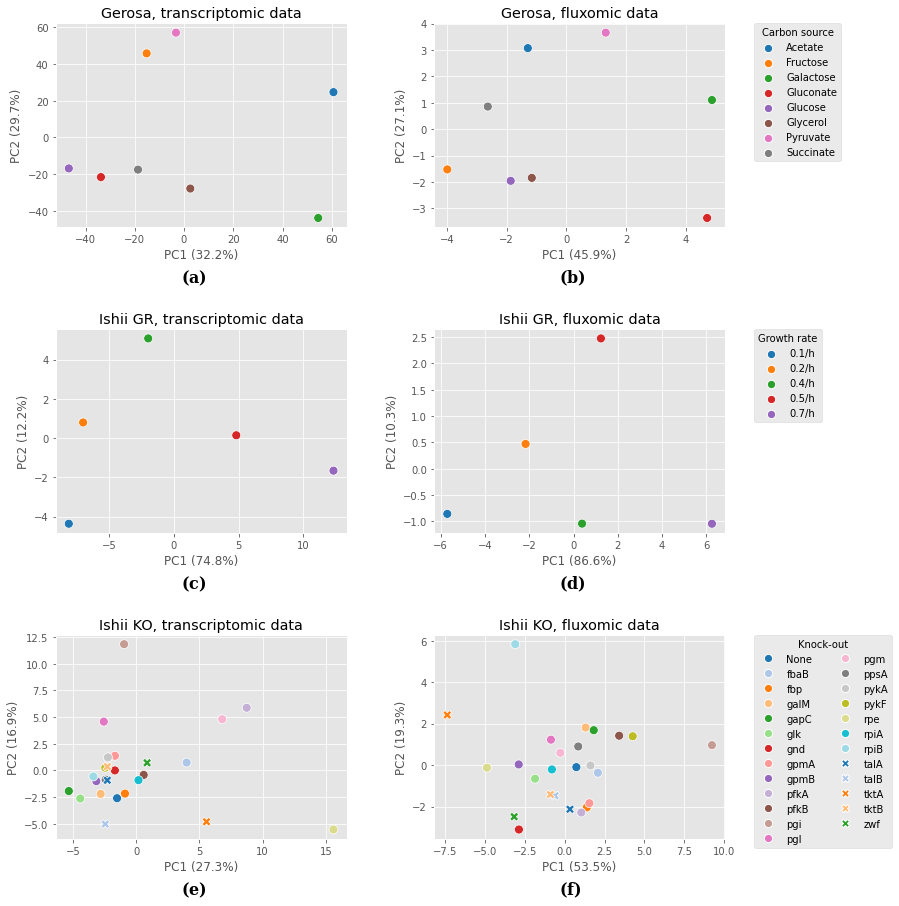

In [13]:
figure_name = 'responses_pca'
suptitle = 'Similarity in samples'
plot_captions = []

nrows = 3
ncols = 2

#Make subplots
fig, axes = plt.subplots(nrows,ncols,figsize = (12,15))

#------------------------- gerosa subplots ---------------------------------------
datasets = datasets_g
hue = 'Condition'
palette = 'tab10'

    
for dataset, ax in zip(datasets, axes[0]):
    #get data and metadata
    [data, data_name, response, perturbation_g, variance_explained, pc_df] = dataset
    
    #plot data
    ax =  plot_pc(data = pc_df.sort_values(by = hue), 
                  variance_explained = variance_explained, 
                  ax=ax, 
                  title = data_name + ', ' + response + ' data',
                  hue = hue, 
                  palette = palette,
                  )
    plot_captions.append(data_name + ', ' + response + ' data')
    
#keep gerosa legend data
handles_g, labels_g = ax.get_legend_handles_labels()
for ha in handles_g: 
    ha.set_edgecolor('white')
    ha.set_linewidth(1)
    ha.set_sizes([70.])
    
#------------------------- ishii GR subplots ---------------------------------------
datasets = datasets_i_gr
hue = 'Condition'
palette = 'tab10'

for dataset, ax in zip(datasets, axes[1]):
    #get data and metadata
    [data, data_name, response, perturbation_i_gr, variance_explained, pc_df] = dataset
    
    #plot data
    ax =  plot_pc(data = pc_df.sort_values(by = hue), 
                  variance_explained = variance_explained, 
                  ax=ax, 
                  title = data_name + ', ' + response + ' data',
                  hue = hue, 
                  palette = palette,
                  )
    plot_captions.append(data_name + ', ' + response + ' data')

#keep ishii GR legend data
handles_i_gr, labels_i_gr = ax.get_legend_handles_labels()
for ha in handles_i_gr: 
    ha.set_edgecolor('white')
    ha.set_linewidth(1)
    ha.set_sizes([70.])
    
#------------------------- ishii KO subplots ---------------------------------------
datasets = datasets_i_ko
hue = 'Condition'
palette = 'tab20'

for dataset, ax in zip(datasets, axes[2]):
    #get data and metadata
    [data, data_name, response, perturbation_i_ko, variance_explained, pc_df] = dataset
    
    #add style because palette only have 20 different colors
    pc_df = pc_df.sort_values(by = hue)
    pc_df.loc[:,'style'] = 0
    pc_df.iloc[20:,pc_df.columns.get_loc('style')] = 1
    
    #plot data
    ax =  plot_pc(data = pc_df, 
                  variance_explained = variance_explained, 
                  ax=ax, 
                  title = data_name + ', ' + response + ' data',
                  hue = hue, 
                  palette = palette,
                  style = 'style',
                  )
    plot_captions.append(data_name + ', ' + response + ' data')
    
#-------------------- add legends -----------------------------------------------            
#gerosa
axes[0][1].legend(handles_g, labels_g,
           bbox_to_anchor=(1.1,1), 
           loc=2,
           ncol=1, 
           borderaxespad=0.,
           title = perturbation_g
          )

#ishii GR
axes[1][1].legend(handles_i_gr, labels_i_gr,
           bbox_to_anchor=(1.1,1), 
           loc=2,
           ncol=1, 
           borderaxespad=0.,
           title = perturbation_i_gr
          )

#ishii KO
axes[2][1].legend(handles = handles_i_ko,
           bbox_to_anchor=(1.1,1), 
           loc=2,
           ncol=2, 
           borderaxespad=0.,
           title = perturbation_i_ko
          )

#--------------------- add figure numbers/caption -------------------------------------
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
                r'$\bf{(c)}$',
                r'$\bf{(d)}$',
                r'$\bf{(e)}$',
                r'$\bf{(f)}$',
               ]

plot_captions = ['','','','','','',''] #when titles instead of cpations

#plot number for transcriptomic
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(0.43, -0.2, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )

#---------------------- save figure -------------------------------------------
#plt.suptitle(suptitle, fontweight='bold', y = 1)
plt.subplots_adjust(wspace=0.3, hspace=0.5) #width and height between subplots
plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            )
plt.show()
plt.close()

### Double check that manually set legend correctly match points

Double check that the manual legend with added style match the automatic one in terms of colors and location in plot:

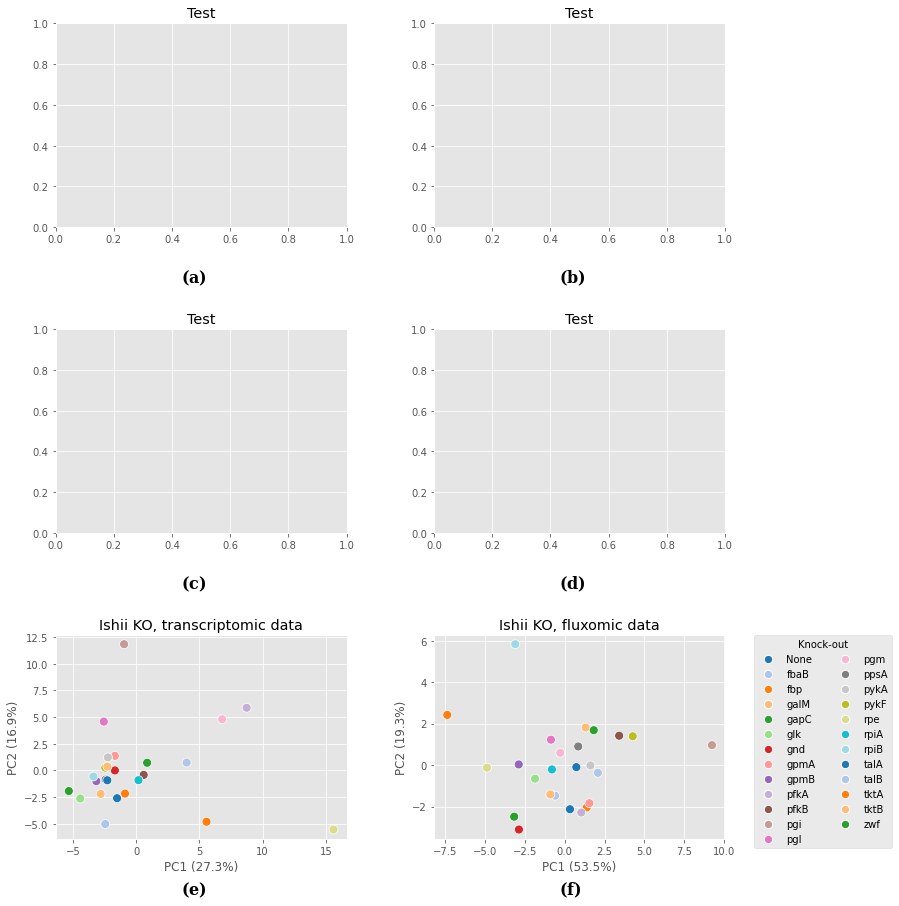

In [14]:
figure_name =  'responses_pca_legend_control'
suptitle = 'PCA of Ishii KO samples'

datasets = datasets_i_ko
nrows = 3
ncols = 2

hue = 'Condition'
palette = 'tab20'

#Make subplots
fig, axes = plt.subplots(nrows,ncols,figsize = (12,15))
        
for ax in axes.flatten():
    ax.set_title('Test')
for dataset, ax in zip(datasets, axes[2]):
    #get data and metadata
    [data, data_name, response, condition, variance_explained, pc_df] = dataset
    #plot data with description
    ax =  plot_pc(data = pc_df.sort_values(by = hue), 
                  variance_explained = variance_explained, 
                  ax=ax, 
                  title = data_name + ', ' + response + ' data',
                  hue = hue, 
                  palette = palette,
                  )
    
    #keep the legend data
    handles, labels = ax.get_legend_handles_labels()
    for ha in handles: 
        ha.set_edgecolor('white')
        ha.set_linewidth(1)
        ha.set_sizes([70.])

#put common legend at the top
plt.legend(handles, labels,
           bbox_to_anchor=(1.1,1), 
           loc=2,
           ncol=2, 
           borderaxespad=0.,
           title = condition
          )
#--------------------- add figure numbers/caption -------------------------------------
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
                r'$\bf{(c)}$',
                r'$\bf{(d)}$',
                r'$\bf{(e)}$',
                r'$\bf{(f)}$',
               ]

plot_captions = ['','','','','','',''] #when titles instead of cpations

#plot number for transcriptomic
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(0.43, -0.2, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )
    
#plt.suptitle(suptitle, fontweight='bold', y = 1)
plt.subplots_adjust(wspace=0.3, hspace=0.5) #width and height between subplots
plt.savefig('%s%s.%s' % (folder_path_figures, figure_name, figure_format), 
            format=figure_format, 
            dpi=200, 
            bbox_inches = 'tight', #include the legend 
            facecolor='white', 
            )
plt.show()
plt.close()

In [15]:
datasets_i_ko[1][5].sort_values(by = 'Condition')

,PC1,PC2,Condition
WT_0.2h-1,0.727922,-0.098127,None
fbaB,2.077950,-0.370428,fbaB
fbp,1.384147,-2.040893,fbp
galM,1.310639,1.811468,galM
gapC,1.819048,1.684443,gapC
glk,-1.861679,-0.656171,glk
gnd,-2.873184,-3.109582,gnd
gpmA,1.545098,-1.839025,gpmA
gpmB,-2.885347,0.031385,gpmB
pfkA,1.035319,-2.289004,pfkA
